In [15]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [16]:
import sys
sys.path.append('../')

import time
import numpy as np
from math import sqrt
from utils import paras
import sys
import os
import pickle
import argparse
import numpy as np
from env import *
from algo import *
from utils import Logger
from bandit_algo import *
import matplotlib.pyplot as plt

In [17]:
eps = 1e-5

In [18]:
class SCO_steam_env:
    def __init__(self, params):
        paras(self, params)
        self.random_seed = params['env']['random_seed']
        self.x_std = params['env']['x_std']
        self.y_std = params['env']['y_std']
        self.p = params['env']['p']
        if np.isinf(self.p):
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)
        self.algo = params['algo']['type']
        self.logger = params['logger']

    def run(self):

        # init theta
        theta = np.zeros(shape=self.size_SCO)  
        theta[:self.s] = 1
        theta /= np.linalg.norm(theta.flatten(), self.p)

        # initialize the baseline risk
        self.algo.logger = self.logger
        super(type(self.algo), self.algo).train(theta)

        self.logger.record('time', time.time())

        #theta = np.random.normal(0, self.x_std, size = (self.d, 1))
        xs = np.random.normal(0, self.x_std, size=(self.T, self.d))
            # x /= np.abs(x).max()
        xs /= np.linalg.norm(xs, self.q, axis = 1, keepdims= True)
        #print(xs.shape, xs.max().max())
        ys = xs.dot(theta)+ np.random.normal(0, self.y_std, size=(self.T, 1))

        for t in range(self.T):
            x, y = xs[[t]], ys[[t]]
            self.algo.update(x.T, y, self.T, t)
            self.logger.record('est_error', np.linalg.norm(self.algo.theta_hat - theta) ** 2)

        self.theta_hat = self.algo.theta_hat

        # testing
        X = np.random.normal(0, self.x_std, size=(10000, self.d))
        X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        y = X.dot(theta) + np.random.normal(0, self.y_std, size=(10000, 1))
        self.risk = ((X.dot(self.theta_hat) - y) ** 2).sum() / 10000
        self.baseline = ((X.dot(np.zeros(self.size_SCO)) - y) ** 2).sum() / 10000
        self.logger.record('baseline', self.baseline)
        self.logger.record('end time', time.time())

In [19]:
class Algo(object):
    def __init__(self, params):
        paras(self, params)

    def update(self, theta0, theta1, x, y):
        pass

    def train(self,theta):
        self.start_time = time.time()
        X = np.random.normal(0, self.x_std, size=(self.test_size, self.d))
        self.X = np.array([x/np.linalg.norm(x, self.q) for x in X])
        self.y = self.X.dot(theta) + np.random.normal(0, self.y_std, size=(self.test_size, 1))
        self.baseline = ((self.X.dot(np.zeros(self.size_SCO)) - self.y) ** 2).sum() / self.test_size
        self.opt_risk = ((self.X.dot(theta) - self.y) ** 2).sum() / self.test_size
        self.logger.record('baseline', self.baseline)

    def test(self, t, theta_hat):
        self.risk = ((self.X.dot(theta_hat) - self.y) ** 2).sum() / self.test_size
        self.subopt = (self.risk - self.opt_risk)/(self.baseline-self.opt_risk)
        self.logger.record('record', [t, self.risk, self.subopt])

In [20]:
class OFW_pge2(Algo):
    '''
    Algorithm for p>2. Learning rate should be <=1
    '''
    def __init__(self, params):
        super().__init__(params)
        self.dt = np.zeros(self.size_SCO)
        self.etat, self.rhot = 1, 1
        self.theta_hat_old, self.theta_hat = np.zeros(self.size_SCO), np.zeros(self.size_SCO)
        self.Gt = np.zeros(self.size_SCO)  # clean summation of g_i up to t
        self.r = 2 # since our theta is normalized to have norm=1

        if np.isinf(self.p):
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)
        self.kappa_q = self.d ** (1 - 2/self.p)
        # self.kappa_q_plus = 1

        self.sigma_plus = self.get_sigma_plus()
        self.noises = self.get_noise()

        self.noise_by_step = self.get_noise_by_step()

    def get_sigma_plus(self):
        logn = np.ceil(np.log2(self.T)) + 1
        sigma_plus_2 = 8 * logn ** 2 * self.kappa_q * np.log(logn / self.delta) * (
                    self.L1 * 2 * self.r + self.L0) ** 2 / self.eps ** 2
        sigma_plus = sigma_plus_2 ** 0.5
        d_pow = 1/2 - 1/self.p
        sigma_plus = sigma_plus / self.d ** d_pow
        return sigma_plus

    def get_noise(self):
        noises = np.zeros((self.d, self.T))
        for i in range(self.T):
            noises[:, i] = GGPlus(self.d, 2, self.sigma_plus)
        return noises

    def push_gt(self, gt):
        self.Gt += gt

    def get_noise_idx(self, t):
        # in each round t, we need to know the indices of nodes we need to get the partial sum
        # these indices will allow use the get the corresponding fixed noises of thoese nodes
        # for example, when t=7, as need node A4+A6+A7,
        # where A4 = g1+g2+g3+g4 + noise, A6 = g5 + g6 + noise, A7 = g7 + noise
        # so we need to get the noise from A4, A6, A7. This function will return [4,6,7] for us.
        # The idea is like, we decompose a number 7 into 4+2+1, the index for node would be 4, 4+2, 4+2+1
        bin_t = format(t, 'b')
        node_idx = []
        for i in range(len(bin_t)):
            if bin_t[i] == '1':
                idx = '1' + '0' * (len(bin_t) - i - 1)
                if len(node_idx) == 0:
                    node_idx.append(int(idx, 2))
                else:
                    node_idx.append(node_idx[-1] + int(idx, 2))
        return node_idx

    # def get_Gt(self, t):
    #     noise_idx = np.array(self.get_noise_idx(t)) - 1
    #     if self.noise_free:
    #         noise = np.zeros(shape=self.size_SCO)
    #     else:
    #         noise = self.noises[:, noise_idx].sum(axis=1)
    #     return self.Gt + noise.reshape(self.size_SCO)

    def get_noise_by_step(self):
        noise_by_step = []

        for t in range(1, self.T+1):
            if self.noise_free:
                noise = np.zeros(shape=self.size_SCO)
            else:
                noise_idx = np.array(self.get_noise_idx(t)) - 1
                noise = self.noises[:, noise_idx].sum(axis=1)
            noise_by_step.append(noise)

        return np.array(noise_by_step)

    def get_Gt(self, t):
        return self.Gt + self.noise_by_step[t-1].reshape(self.size_SCO)


    def update(self, x, y, T, t):

        t = t + 1  # python starting from 0, while our algo starts from 1
        self.etat, self.rhot = 1 / (t + 1), 1 / (t + 1)

        self.etat = self.etat * self.lr_scale
        self.rhot = self.rhot * self.lr_scale

        gradient0, gradient1 = compute_linear_gradient(self.theta_hat_old, x, y), compute_linear_gradient(
            self.theta_hat, x, y)
        gt = (t + 1) * gradient1 - t * gradient0
        self.push_gt(gt)
        Gt = self.get_Gt(t)
        self.dt = Gt / (1 + t)
        if np.isinf(self.p):
            v = - np.sign(self.dt) * self.r
        else:
            v = -1 * np.sign(self.dt) * np.abs(self.dt) ** (self.q - 1) * self.r / np.linalg.norm(self.dt.flatten(), self.q) ** (self.q - 1)
        self.theta_hat_old = copy.copy(self.theta_hat)
        self.theta_hat = self.theta_hat + self.etat * (v - self.theta_hat)

        # we control the total number of testing time to be self.test_freq
        if (self.test_flag==True) and (t % max(1, (T // self.test_freq)) == 0):
            self.test(t, self.theta_hat)
        self.logger.record('iteration', t)
        self.logger.record('time', time.time() - self.logger.dict['time'][0])

    def decide(self, X, t):
        reward = list()
        for i in range(self.k):
            reward.append(self.theta_hat.T.dot(X[:, i]))
        at = np.argmax(reward)
        return at

In [21]:
def generate_params(algo, seed, p, d = 5, T = int(1e2), scale = 1, noise_free = False, test_flag = False):  
    params = dict()
    params['env'] = {"random_seed": seed,
                     "T": T,
                     "d": d,
                     "s": 5,  
                     "k": 5,
                     "p": p, 
                     "x_std": 0.05,
                     "y_std": 0.05,
                     "test_size": 1000, 
                     "test_freq" : T,
                     }

    np.random.seed(seed)
    
    logger = Logger()
    params['prv'] = {"eps": 1,
                     "delta": 1/params['env']['T']}
    params['logger'] = logger
    params['algo'] = dict()
    params['algo']['lr_scale'] = scale
    params['algo']['noise_free'] = noise_free
    params['algo']['test_flag'] = test_flag
    params['bandit'] = dict()
    if algo == 'OFW_ple2':
        params['algo']['type'] = OFW_ple2(params)
        env = SCO_steam_env(params)
    elif algo == 'OFW_pge2':
        params['algo']['type'] = OFW_pge2(params)
        env = SCO_steam_env(params)
    elif algo == 'Local_MD':
        params['algo']['type'] = Local_MD(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySFW':
        params['algo']['type'] = NoisySFW(params)
        env = SCO_batch_env(params)
    elif algo=='NoisySGD':
        params['algo']['type'] = NoisySGD(params)
        env = SCO_batch_env(params)
    elif algo=='DPUCB':
        params['algo']['type'] = DPUCB(params)
        params['bandit']['multi'] = False
        env = bandits_env(params)
    elif algo=='OFW_peq1':
        params['algo']['type'] = OFW_peq1(params)
        params['bandit']['multi'] = True
        env = bandits_env(params)
        
    env.run()
    params['result'] = env.logger.dict
    return p, d, T, algo, str(scale), str(noise_free), str(test_flag), params


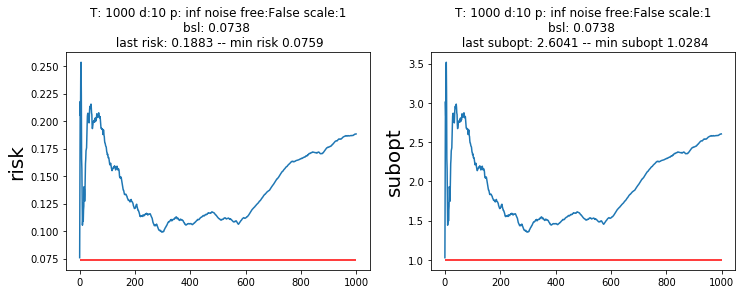

In [22]:
seed = 10
p = np.inf
T = 1000
d = 10
eta_scaling = 1
test_flag = True
noise_free = False
p, d, T, algo, scale, noise_free, test_flag, params  = generate_params('OFW_pge2', seed=seed, p=p, d=d, T=T, scale=eta_scaling,
                                                                      noise_free = noise_free, test_flag = test_flag)


f, axs = plt.subplots(1, 2, figsize=(12,4))
risk = [r[1] for r in params['result']['record']]
axs[0].plot(risk)
axs[0].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last risk: {:.4f} -- min risk {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][1],
    min(risk),
))
axs[0].hlines(params['result']['baseline'][0], 0, T, 'r')
axs[0].set_ylabel('risk', fontsize=20)

subopt = [r[2] for r in params['result']['record']]
axs[1].plot(subopt)
axs[1].set_title('T: {} d:{} p: {} noise free:{} scale:{}\nbsl: {:.4f} \n last subopt: {:.4f} -- min subopt {:.4f}'.format(
    T, d, p, noise_free, scale,
    params['result']['baseline'][0],
    params['result']['record'][-1][2],
    min(subopt),
))
axs[1].hlines(1, 0, T, 'r')
axs[1].set_ylabel('subopt', fontsize=20)

plt.show()

### compare the GGNoise when p=2 with normal distributuin

Text(0.5, 1.0, 'std=1')

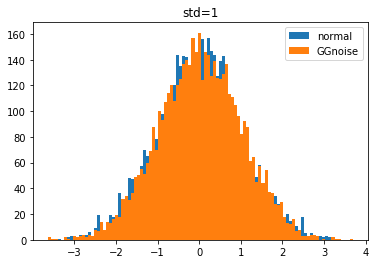

In [23]:
std = 1
n_bins = 100

normal = np.random.randn(5000)
normal = normal * std

gg = []
for i in range(5000):
    n = GGPlus(d=1, p=2, sigma_plus=std)
    gg.append(n)
gg = np.array(gg).squeeze()

bins = np.histogram(np.hstack((gg,normal)), bins=n_bins)[1] #get the bin edges
    
plt.hist(normal, bins, label='normal')
plt.hist(gg, bins, label='GGnoise')
plt.legend()

plt.title(f'std={std}')

Text(0.5, 1.0, 'std=2')

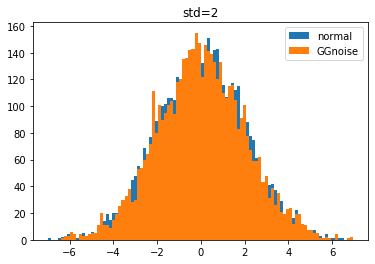

In [24]:
std = 2
n_bins = 100

normal = np.random.randn(5000)
normal = normal * std

gg = []
for i in range(5000):
    n = GGPlus(d=1, p=2, sigma_plus=std)
    gg.append(n)
gg = np.array(gg).squeeze()

bins = np.histogram(np.hstack((gg,normal)), bins=n_bins)[1] #get the bin edges
    
plt.hist(normal, bins, label='normal')
plt.hist(gg, bins, label='GGnoise')
plt.legend()

plt.title(f'std={std}')

Text(0.5, 1.0, 'std=0.5')

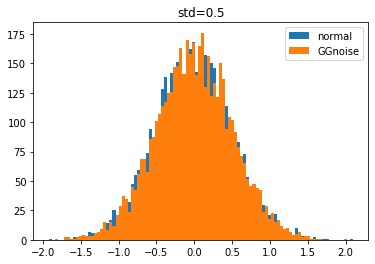

In [25]:
std = 0.5
n_bins = 100

normal = np.random.randn(5000)
normal = normal * std

gg = []
for i in range(5000):
    n = GGPlus(d=1, p=2, sigma_plus=std)
    gg.append(n)
gg = np.array(gg).squeeze()

bins = np.histogram(np.hstack((gg,normal)), bins=n_bins)[1] #get the bin edges
    
plt.hist(normal, bins, label='normal')
plt.hist(gg, bins, label='GGnoise')
plt.legend()

plt.title(f'std={std}')